In [36]:
import torch.nn as nn
import torch
import torch.nn.functional as F

import numpy as np
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import LRScheduler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics         import mean_absolute_error, mean_squared_error, accuracy_score

from zipfile import ZipFile

In [2]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d vijayadityads/income-evaluation

In [4]:
with ZipFile('income-evaluation.zip') as zip_file:
  data = pd.read_csv(zip_file.open(zip_file.namelist()[0]))

In [5]:
def convert_non_numerical(data):
	'''
	Converts variables with non numerical data into numerical variables
	-----------------------------------------------------
	-----------------------------------------------------
	Parameters:
		Data: Dataset loaded

	Returns:
		Data: Factorized Dataset

	'''
	non_numerical = ['workclass',
					'fnlwgt',
					'education',
					'marital-status',
					'occupation',
					'relationship',
					'race',
					'sex',
					'native-country',
					'income']

	labels        = {}
	for col in data:
		cleaned_column = col.strip()
		if cleaned_column in non_numerical:

			labels[col] = pd.factorize(data[col])[1]
			data[col]   = pd.factorize(data[col])[0]

	return data, labels


data, factorized_labels = convert_non_numerical(data)

In [6]:
TEST_SIZE    = 0.2
RANDOM_STATE = 42
x_data       = data[[col for col in data.columns if col != ' income']]
targets      = data[' income']
x_data       = torch.tensor(x_data.values, dtype = torch.float32)
targets      = torch.tensor(targets.values,  dtype = torch.float32)

x_train, x_test, y_train, y_test = train_test_split(x_data,
													targets,
													test_size   = TEST_SIZE,
													random_state = RANDOM_STATE)

x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = RANDOM_STATE)

In [68]:
class MyCustomScheduler(LRScheduler):
    def __init__(self, optimizer, last_epoch=-1):
        # super().__init__(optimizer, last_epoch)
        super().__init__(optimizer, last_epoch)

        self.last_epoch = last_epoch

    def get_lr(self):

        '''
        This method is called with every epoch
        '''

        # self.last_epoch stores epoch number
        if self.last_epoch % 5 == 0 and self.last_epoch != 0:
          self.base_lrs = [base_lr * 0.5 for base_lr in self.base_lrs]

        else:
          self.base_lrs = self.base_lrs

        return self.base_lrs




In [ ]:
class BasicClassification(nn.Module):

	def __init__(self,
			  	input_size = len(x_train[0, :]),
				fc1_out    = 64,
				fc2_out    = 64,
				fc3_out    = 32):

		super().__init__()

		self.fc1    = nn.Linear(input_size, fc1_out)
		self.fc2    = nn.Linear(fc1_out, fc2_out)
		self.fc3    = nn.Linear(fc2_out, fc3_out)
		self.output = nn.Linear(fc3_out, 1)

	def forward(self, x):

		x      = F.relu(self.fc1(x))
		x      = F.relu(self.fc2(x))
		x      = F.relu(self.fc3(x))
		output = F.sigmoid(self.output(x))

		return output


def train_model(model, epochs = 20, base_lr = 0.001, batch_size = 64):

	'''
	Training Loop for the main model

	Parameters:
	- Model:


	Returns:
	-


	'''


	optimizer  = torch.optim.Adam(lr = base_lr, params = model.parameters())
	loss_fn    = nn.BCELoss()
	# scheduler  = lr_scheduler.ReduceLROnPlateau(optimizer,  mode='max', factor=0.1,
	# 											  patience=4, threshold=0.0001,
	# 											  threshold_mode='rel', cooldown=0,
	# 											  min_lr=0, eps=1e-08, verbose=False)


	# scheduler    = lr_scheduler.ExponentialLR(optimizer, gamma = 0.8)
	scheduler  = MyCustomScheduler(optimizer)

	losses     = []
	batches    = math.floor(x_train.shape[0] / batch_size)
	for epoch in range(EPOCHS):

		intermediate_losses = []
		for batch in range(1, batches + 1):

			train_batch    = x_train[(batch - 1)*batch_size:batch*batch_size]
			targets        = y_train[(batch - 1)*batch_size:batch*batch_size]
			y_pred         = model.forward(train_batch)
			y_pred         = y_pred.squeeze(1)
			loss           = loss_fn(y_pred, targets.float())
			intermediate_losses.append(loss.detach().numpy())
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

		scheduler.step()

		losses.append(np.average(intermediate_losses))
		print('Epoch: {}  | Loss: {} | Current LR {}'.format(epoch, np.average(intermediate_losses), scheduler.get_last_lr()))


	return model, losses

EPOCHS     = 20
model      = BasicClassification()

model, losses = train_model(model, epochs = EPOCHS)

Model Accuracy 0.7641277641277642


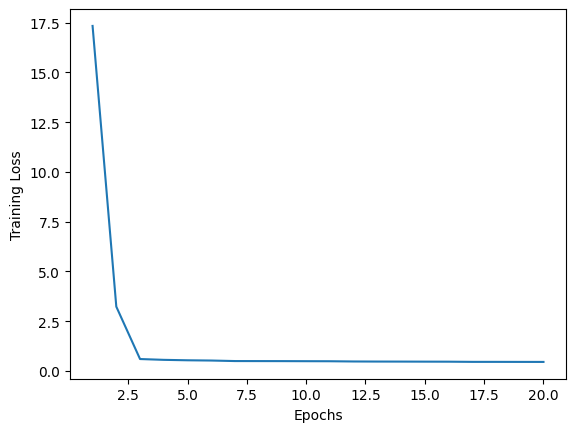

In [81]:
def evaluate_model(x_test, y_test, plot = True):
	predictions = model(x_test.float())
	predictions = predictions.detach().numpy()
	predictions = predictions.astype(int)

	y_test      = y_test.detach().numpy()
	accuracy    = accuracy_score(predictions, y_test)
	print('Model Accuracy', accuracy)

	if plot:
		plt.plot(range(1, EPOCHS + 1), losses)
		plt.xlabel('Epochs')
		plt.ylabel('Training Loss')


	return

evaluate_model(x_test, y_test)

